In [1]:
import pandas as pd
from src.core.pivot_handler import PivotHandler
from src.core.segmentation_handler import CumulativeSegmentsSplitter
from src.models.models import get_data
from src.core.segmentation_handler import SegmentationHandler
from src.core.hypothesis_evaluation.test_evaluation import StatisticalTestHandler
from src.utils.tools import update_column_names,experiment_name,extract_experiment_name
from datetime import datetime

from src.core.budget_evaluation import compute_result_budget

from src.core.hypothesis_evaluation.test_handler import run_tests_for
from itertools import product
from scipy import stats
import datetime


## Arguments 
test_type = "mean"
test_arg = 'Two-Samples'


error_correction_test = "FDR"
threshold = 0.05
plot = False


df_data  = get_data()
df_data["purchase"] = 1
pivot_handler = PivotHandler()
segmentation_handler = SegmentationHandler()
test_handler = StatisticalTestHandler()

In [27]:
from datetime import datetime 
df_data = get_data().reset_index()

before = df_data[df_data.transaction_date<=datetime(2018,12,17)].index[-9000:]
after = df_data[df_data.transaction_date<=datetime(2018,12,17)].index[:700]

df_data = df_data.loc[set(before).union(after)].set_index("transaction_date")
df_data.shape

(9700, 3)

In [12]:
from datetime import datetime 
pivots = [
    ("Trend",["Up","Other"]),
    ("temporal", [datetime(2018,12,17),datetime(2019,2,28)]),
#     (None,[1]),
#     (None,[5]),
#     (None,[20]),
    ( "Demographics",["gender"])
]
segmentations = [
#     (None,""),
#     ("temporal",200),
#     ("demographic","gender"),
    ("trend",["Up","Other"]),
]
res = []

for (pivot_type,pivot_arg),(segmentation_type,segmentation_arg) in product(pivots,segmentations):
    if pivot_type is None:
        test_arg = 'One-Sample'
    else:
        test_arg = 'Two-Samples'
        
    df = df_data.copy()
    name  = experiment_name(pivot_type,pivot_arg,segmentation_type,segmentation_arg)
    try:
        result = run_tests_for(df,pivot_type,pivot_arg,segmentation_type,segmentation_arg,test_type,test_arg,error_correction_test,threshold,plot)
        print("Done",name)
    except Exception as e :
        print("Error for ",name,e)
        continue
    
    if not len(result):
        continue
    pd.DataFrame(result).to_csv("experiments/results/RETAIL_SOME/"+name+".csv")


Pivot
Segmentation 90 1212


/home/abdelouahab/PHD/SSQ/src/core/hypothesis_evaluation/test_evaluation.py:69: RuntimeWarning: invalid value encountered in true_divide
  values_1 = (values_1 - min(values_1)) / (max(values_1) - min(values_1))
/home/abdelouahab/.virtualenvs/SSQ/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/abdelouahab/.virtualenvs/SSQ/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/abdelouahab/.virtualenvs/SSQ/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/abdelouahab/.virtualenvs/SSQ/lib/python3.8/site-packages/scipy/stats/stats.py:1603: 

Results
Done pivot: Trend ['Up', 'Other'] , segmentation: temporal 200
Pivot
Segmentation 801 356


KeyboardInterrupt: 

In [29]:
result

,t_Other,t_size,r_Up,r_size,t-value,p-value,t_normal,r_normal,chi-squared test,R_size,T_size,#r,#t,segmentation,pivot,test,p-value (FDR)


In [31]:
files

["ls: cannot access 'results/experiments/*.csv': No such file or directory"]

In [38]:
from statsmodels.stats.multitest import multipletests


files = !ls experiments/results/*.csv
error_arg = "fdr_bh"
plots = pd.DataFrame()
for i in files:
    if any(ii in  i for ii in ["demographic gender"]):
        continue
    result = pd.read_csv(i,index_col=0)
  
    result = result[result["chi-squared test"]>=0.05]
    corrected_err_column = f'p-value {error_arg}'
    result[corrected_err_column] = multipletests(result["p-value"],method=error_arg)[1]
    budget = result[corrected_err_column].max()*result.shape[0]
    plot_data = compute_result_budget(result,budget,corrected_err_column,plot=False,title=None)
    name = i.replace('.csv',"").replace("pivot: temporal ['2018-12-17', '2019-02-28']","pivot: promotions [Before,After]")
    plot_data.columns = ["coverage","budget "+name ]
    plots= pd.concat([plots,plot_data])
    print(i)

KeyError: '#r'

In [35]:
import matplotlib.pyplot as plt
plots

""


In [34]:
plt.rcParams["font.size"] = "16"
columns =["coverage"]+[ii for ii in plots.columns if "pivot: behav" in ii]
d = plots[columns].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).plot(figsize=(20,8))
title="Budget consumption of Trend pivot"


KeyError: "None of [Index(['coverage'], dtype='object')] are in the [columns]"

In [120]:
columns =["coverage"]+[ii for ii in plots.columns if "pivot: demog" in ii and "500" not in ii and '400' not in ii]
d = plots[sorted(columns)].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).plot(figsize=(20,8))
title="Budget consumption of demographic pivot"

In [121]:
columns =["coverage"]+[ii for ii in plots.columns if "pivot: promo" in ii and "500" not in ii and '400' not in ii and "gender" not in ii and "20" not in ii]
d = plots[columns].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).plot(figsize=(20,8))
title="Budget consumption of promotions pivot"


In [16]:
experiment_name(pivot_type,pivot_arg,segmentation_type,segmentation_arg)

"pivot: Trend ['Up', 'Other'] , segmentation: temporal W"

In [59]:
r =[]
for i in range(0,len(res)):
    r.append((*res[i][1].split(" , "),res[i][0]["p-value (FDR)"].max(),res[i][0].shape[0],res[i][0]["p-value (FDR)"].max()*res[i][0].shape[0]))
pd.DataFrame(r,columns = ["pivot","segmentation","max(ap-val)","#result","#results * max(ap-val)"])

,pivot,segmentation,max(ap-val),#result,#results * max(ap-val)
0,"pivot: Trend ['Up', 'Other']",segmentation: temporal 100,4.813140e-02,1393,6.704704e+01
1,"pivot: Trend ['Up', 'Other']",segmentation: temporal 50,4.995776e-02,4655,2.325534e+02
2,"pivot: Trend ['Up', 'Other']",segmentation: demographic gender,2.957970e-27,4,1.183188e-26
3,"pivot: Trend ['Up', 'Other']","segmentation: trend ['Up', 'Other']",4.925499e-02,12,5.910599e-01
4,"pivot: temporal ['2018-12-17', '2019-02-28']",segmentation: temporal 100,4.996082e-02,4703,2.349657e+02
5,"pivot: temporal ['2018-12-17', '2019-02-28']",segmentation: temporal 50,4.999523e-02,10834,5.416483e+02
6,"pivot: temporal ['2018-12-17', '2019-02-28']",segmentation: demographic gender,1.523697e-02,3,4.571092e-02
7,pivot: Demographics ['gender'],segmentation: temporal 100,2.140246e-02,159,3.402992e+00
8,pivot: Demographics ['gender'],segmentation: demographic gender,1.840286e-192,1,1.840286e-192


In [48]:
a = pd.DataFrame()
for a,b in res:
    break
plot_data = compute_result_budget(a,a["p-value"].shape[0]*a["p-value"].max(),plot=False,title=b)
plot_data.columns = ["coverage",b]


,coverage,budget
9,0.000000,63.664977
0,0.111111,63.664975
1,0.222222,63.664974
2,0.333333,63.664973
3,0.444444,63.664971
4,0.555556,63.664966
5,0.666667,63.664961
6,0.777778,63.664955
7,0.888889,63.664910
8,1.000000,63.659761


In [108]:
def plot_results(res):
    d = pd.DataFrame()
    for a,b in res:
        plot_data = compute_result_budget(a,a["p-value"].shape[0]*a["p-value"].max(),plot=False,title=b)
        plot_data.columns = ["coverage",b]
        d = pd.concat([d,plot_data])
    d = d.set_index("coverage").sort_index().interpolate()
    ax = (d/d.max()).plot(figsize=(20,8),title="Budget consumption of different pivots")
plt.rcParams["font.size"] = "16"

res = [i for i in res_copy.copy() if "pivot: be" in i[1]]
plot_results(res)

In [109]:
res = [i for i in res_copy.copy() if "pivot: te" in i[1]]
plot_results(res)

In [110]:
res = [i for i in res_copy.copy() if "pivot: de" in i[1]]
plot_results(res)

In [78]:
import numpy as np
import matplotlib.pyplot as plt

res = [i for i in res_copy.copy() if "Up"in i[1]]
a,b = res[0]

plot_data = compute_result_budget(a,a["p-value"].max()*a.shape[0],plot=False,title=b)
plot_data.columns = ["coverage",b]
ax = plot_data.set_index("coverage").plot(figsize=(20,8))

for a,b in res:
    plot_data = compute_result_budget(a,a["p-value"].shape[0]*a["p-value"].max(),plot=False,title=b)
    plot_data.columns = ["coverage",b]
    plot_data.set_index("coverage").plot(ax=ax)
plt.show()


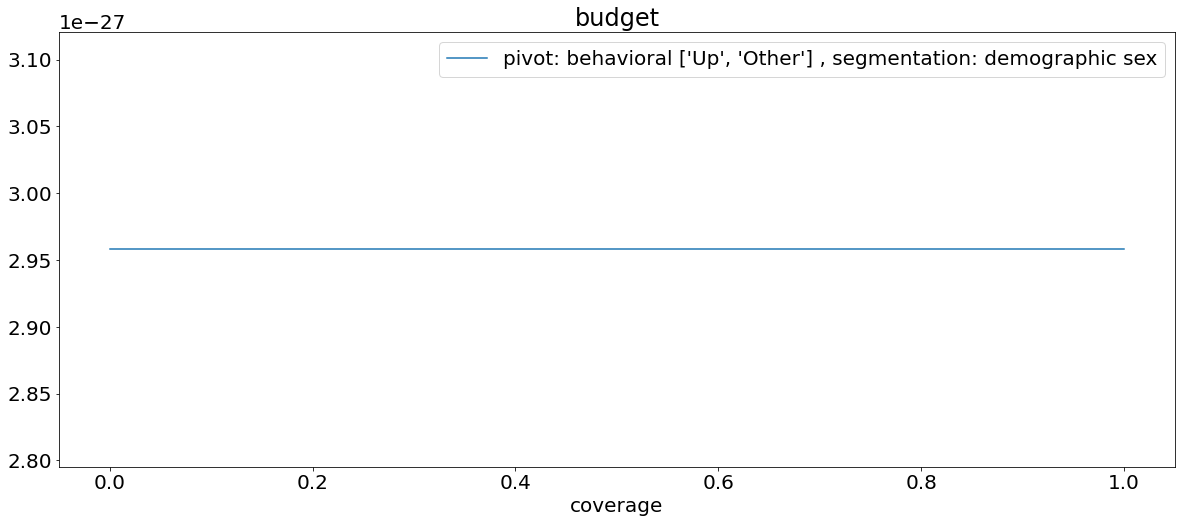

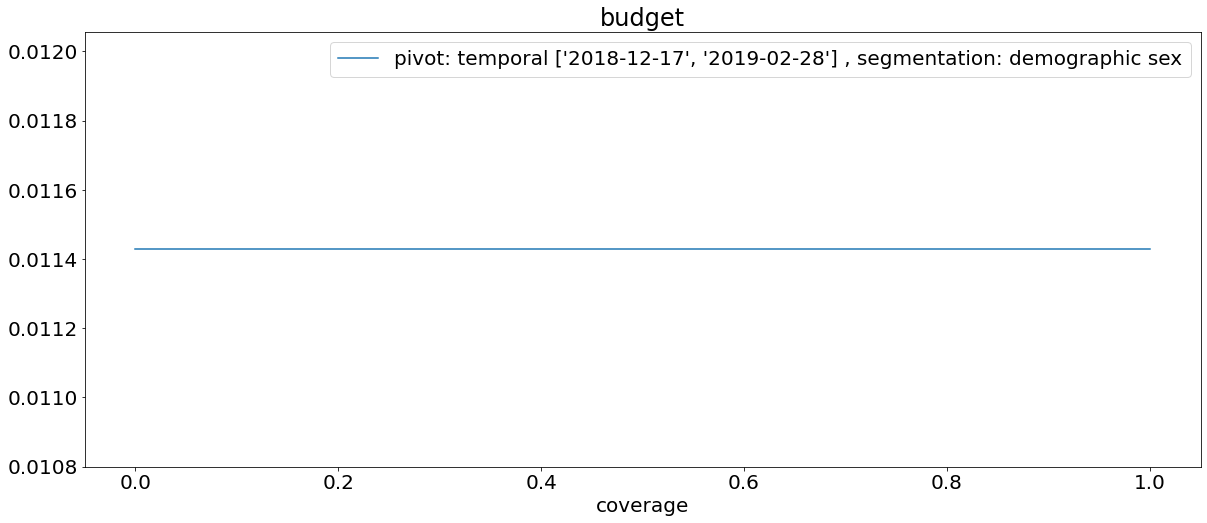

In [16]:
plt.rcParams["font.size"] = "20"
for a,b in res:
    if "temporal 400" in b:
        continue
    plot_data = compute_result_budget(a,a["p-value"].sum(),plot=False,title=b)
    plot_data.columns = ["coverage",b]
    plot_data.set_index("coverage").plot(title="budget",figsize=(20,8))
    plt.show()

In [220]:
def compute_result_budget(result,budget,plot=False,title=None):
    r = [i for i in result.columns if "r_" in i ][0]
    result = result.set_index(["p-value (FDR)",r]).sort_index()


    ## Remove duplicates in index 
    result = result[~result.index.get_level_values(1).duplicated(keep="first")]
    result["p-value"] = result.index.get_level_values(0)

    # Compute budget 
    def compute_budget(result,budget):
        index = result.index
        for i in index:
            result.loc[i,"budget"] = budget - result.loc[:i].shape[0] * result.loc[:i,'p-value'].max()
    compute_budget(result,budget)
    # coverage 
    result["coverage"] = 1
    result["coverage"] = result["coverage"].cumsum() /result["#r"].unique()[0] 


    # plot 
    plot_data = result[result["budget"]>=0].reset_index()[["coverage","budget"]]
    plot_data.loc[len(plot_data)]=[0,budget]
    plot_data = plot_data.sort_values("coverage")
    if plot:
        ax = plot_data.plot.line(x="coverage",y="budget",title=title,figsize=(20,8))
    return plot_data


In [13]:
pd.read_csv("results_example.csv",index_col=0)

,t_>2019-02-28,t_size,r_<2018-12-17,r_size,t-value,p-value,R_size,T_size,#r,#t,segmentation,pivot,test,p-value (FDR)
821,"200, [2019-02-28,2019-11-08]",200,"200, [2017-04-05,2018-12-13]",200,7.313447,5.908487e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
838,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-11,2018-12-14]",200,7.282992,7.554008e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
816,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-05,2018-12-11]",200,7.275560,7.932785e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
827,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-11,2018-12-17]",200,7.262562,8.684162e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
845,"200, [2019-02-28,2019-11-08]",200,"195, [2017-06-02,2018-12-17]",195,7.265274,8.706355e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,"200, [2019-03-04,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.776233,5.638996e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,5.875112e-03
105,"200, [2019-02-28,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.772189,5.708022e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,5.942149e-03
1092,"200, [2019-02-28,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.714986,6.782334e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,7.054739e-03
904,"200, [2019-02-28,2019-12-26]",200,"200, [2017-10-05,2018-12-14]",200,2.700758,7.077229e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,7.355450e-03


In [10]:
!ls *.csv

 all_experiments.csv
''\''_'\''.join(str(i) for i in [pivot_type,pivot_arg,segmentation_type,segmentation_arg,test_type,test_arg,error_correction_test,threshold,plot]).csv'
 partitionning_cumulative_0.1.csv
 partitionning_cumulative_0.2.csv
 partitionning_cumulative_0.35.csv
 partitionning_cumulative_0.5.csv
 partitionning_cumulative_0.csv
 results_example.csv
 starting_data.csv
 temporal_segmentaiton_results.csv
 test.csv


In [72]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X = np.linspace(0,1,1000)
Y = np.cos(X*20)

ax1.plot(X,Y)
ax1.set_xlabel(r"Original x-axis: $X$")

new_tick_locations = np.array([.2, .5, .9])

def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
plt.show()

In [ ]:
df_stats = pd.DataFrame(res)
df_stats.columns = ["pivot",'pivot_arg','segmentation','segmentation_arg','agg','','error control','alpha','#results',"sum ap-value",'r_coverage','t_coverage'] 
df_stats

In [20]:
'_'.join(str(i) for i in [pivot_type,pivot_arg,segmentation_type,segmentation_arg,test_type,test_arg,error_correction_test,threshold,plot])

"Demographics_['gender']_temporal_Y_mean__FDR_0.05_False"

In [26]:
print(df_stats.to_latex(index=False))

\begin{tabular}{lllllllrrrrr}
\toprule
       pivot &         pivot\_arg & segmentation & segmentation\_arg &  agg & {} & error control &  alpha &  \#results &  sum ap-value &  r\_coverage &  t\_coverage \\
\midrule
Demographics & ['gender'] (r=F,t=M) &     temporal &                W & mean & {} &           FDR &   0.05 &     21904 &  1.942374e+02 &    0.993289 &    0.993289 \\
Demographics & ['gender'] (r=F,t=M) &     temporal &               2W & mean & {} &           FDR &   0.05 &      5625 &  5.109631e+01 &    1.000000 &    1.000000 \\
Demographics & ['gender'] (r=F,t=M) &     temporal &               3W & mean & {} &           FDR &   0.05 &      2500 &  3.000554e+01 &    0.980392 &    0.980392 \\
Demographics & ['gender'] (r=F,t=M) &     temporal &                M & mean & {} &           FDR &   0.05 &      1156 &  2.267783e-06 &    1.000000 &    0.971429 \\
Demographics & ['gender'] (r=F,t=M) &     temporal &               3M & mean & {} &           FDR &   0.05 &       144 &

In [30]:
df_stats[["r_coverage","t_coverage"]].apply(lambda x : f'{x}')

0    r_coverage    0.993289\nt_coverage    0.993289...
1    r_coverage    1.0\nt_coverage    1.0\nName: 1,...
2    r_coverage    0.980392\nt_coverage    0.980392...
3    r_coverage    1.000000\nt_coverage    0.971429...
4    r_coverage    1.000000\nt_coverage    0.923077...
5    r_coverage    1.000000\nt_coverage    0.857143...
6    r_coverage    1.0\nt_coverage    0.8\nName: 6,...
7    r_coverage    1.0\nt_coverage    1.0\nName: 7,...
dtype: object

In [3]:
temporal_pivot_argument = [df.index[300],df.index[500]]
reference_set,test_set = pivot_handler.pivot("temporal",df,temporal_pivot_argument)
print(reference_set.shape,test_set.shape)

(1371891, 9) (482113, 9)


In [9]:
isinstance(test_set, pd.DataFrame)

True

In [4]:
temporal_pivot_argument 

[Timestamp('2017-12-09 00:00:00'), Timestamp('2017-11-16 00:00:00')]

In [14]:
splitter = CumulativeSegmentsSplitter()

TypeError: 'CumulativeSegmentsSplitter' object is not callable

In [10]:
import numpy as np

In [12]:
np.diff([1,2,3],[1,2])

TypeError: '<' not supported between instances of 'list' and 'int'

In [50]:
def a(b=[]):
    b.append(123)
    print(b)

a()
a()
a()

[123]
[123, 123]
[123, 123, 123]


In [52]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/abdelouahab/.virtualenvs/SSQ/bin/python
3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [49]:
a()

[123, 123, 123]
